# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, Imputer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv',sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv',sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.shape

(891221, 85)

In [5]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [6]:
feat_info.shape

(85, 4)

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [7]:
# Number of naturally missing values
azdias.isnull().sum().sum()

4896838

In [8]:
for feat in range(len(feat_info)):
    miss_vals = feat_info.iloc[feat][3]
    miss_vals = miss_vals.strip('[').strip(']').split(sep=',')
    miss_vals = [int(val) if (val!='' and val!='X' and val!='XX') else val for val in miss_vals]
    if miss_vals != ['']:
        azdias = azdias.replace({feat_info.iloc[feat][0]: miss_vals}, np.nan)

In [9]:
# number of missing values after conversion
azdias.isnull().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

In [10]:
# Assessment of how much missing data there is in each column, count and percentage.

null_data = azdias.isnull().sum()[azdias.isnull().sum() != 0]
data_dict = {'null_count': null_data.values, 'null_pct': np.round(null_data.values/len(azdias)*100,2)}
azdias_null = pd.DataFrame(data = data_dict, index = null_data.index)
azdias_null.sort_values(by='null_pct', ascending=False, inplace=True)
azdias_null

,null_count,null_pct
TITEL_KZ,889061,99.76
AGER_TYP,685843,76.96
KK_KUNDENTYP,584612,65.60
KBA05_BAUMAX,476524,53.47
GEBURTSJAHR,392318,44.02
ALTER_HH,310267,34.81
KKK,158064,17.74
REGIOTYP,158064,17.74
W_KEIT_KIND_HH,147988,16.61
KBA05_ANTG3,133324,14.96


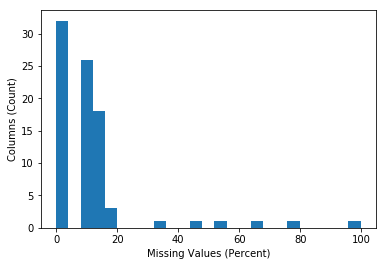

In [11]:
# Assesment of percentage of missing values by number of columns.
pct_miss = (azdias.isnull().sum()/len(azdias))*100

plt.hist(pct_miss, bins=25)
plt.xlabel('Missing Values (Percent)')
plt.ylabel('Columns (Count)')
plt.show()

In [12]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

# Outlier columns with more than 20% of missing data
drop_out = pct_miss[pct_miss>20].index.tolist()
print('Outlier columns with more than 20% missing data:{}'.format(drop_out))

Outlier columns with more than 20% missing data:['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']


In [13]:
# Dropping outlier columns
azdias = azdias.drop(drop_out, axis=1)

In [14]:
azdias.shape

(891221, 79)

#### Discussion 1.1.2: Assess Missing Data in Each Column

Most columns (61) have a number of missing values, from 0.32% to 99,76% of their corresponding total of values. As it is illustrated in the histogram, most columns in the dataset have less than 20% of missing values so we consider columns with more than 20% of missing values (6) as outliers and are therefore removed from the dataset. As a result the total number of columns is reduced from 85 to 79.

The labels of the dropped columns are: 'AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP' and 'KBA05_BAUMAX'.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

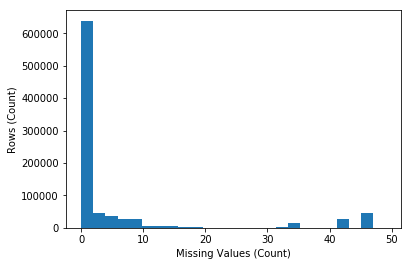

In [15]:
# How much data is missing in each row of the dataset?
row_miss = azdias.isnull().sum(axis=1)
plt.hist(row_miss, bins=25)
plt.ylabel('Rows (Count)')
plt.xlabel('Missing Values (Count)')
plt.show()

In [16]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
rows_few = azdias[azdias.isnull().sum(axis=1) <= 20]
rows_many = azdias[azdias.isnull().sum(axis=1) > 20]

In [17]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
col_zeromiss = pct_miss[pct_miss == 0].index.tolist()
col_compare = col_zeromiss[:6]

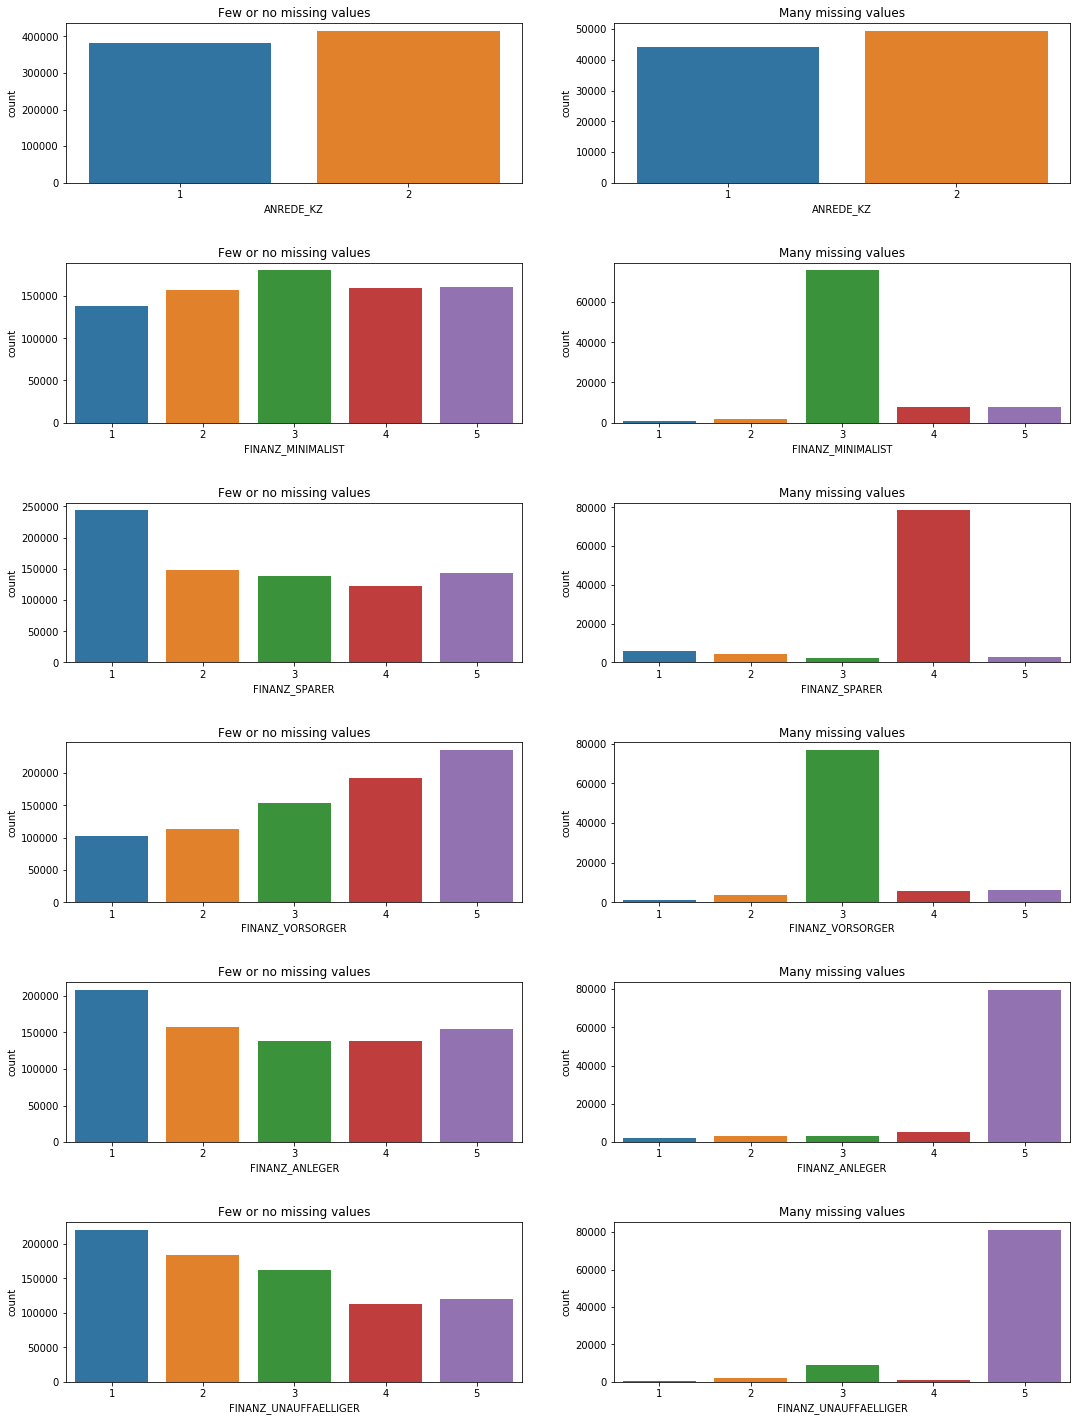

In [18]:
figure, axs = plt.subplots(nrows=len(col_compare), ncols=2, figsize = (18,25))
figure.subplots_adjust(hspace = .5, wspace=.2)
for i in range(len(col_compare)):
    sns.countplot(rows_few[col_compare[i]], ax=axs[i][0])
    axs[i][0].set_title('Few or no missing values')
    sns.countplot(rows_many[col_compare[i]], ax=axs[i][1])
    axs[i][1].set_title('Many missing values')

#### Discussion 1.1.3: Assess Missing Data in Each Row

In both datasets the gender column was similarly distributed, with populations being mostly female. The rest of the columns representing financial features had distributions that are greatly different between the datasets. As a result dropping data with many missing values would introduce bias into the analysis.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [19]:
# How many features are there of each data type?
features = list(rows_few.columns)
feat_info_cl = feat_info[feat_info['attribute'].isin(features)]
tp_count = feat_info_cl['type'].value_counts()
for i in range(len(tp_count)):
    print('{} {}'.format(tp_count[i], tp_count.index[i]))

49 ordinal
18 categorical
6 numeric
6 mixed


#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [20]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical = feat_info_cl[feat_info_cl["type"]=="categorical"]["attribute"]
categorical

2            ANREDE_KZ
3        CJT_GESAMTTYP
10           FINANZTYP
12     GFK_URLAUBERTYP
13    GREEN_AVANTGARDE
17     LP_FAMILIE_FEIN
18     LP_FAMILIE_GROB
19      LP_STATUS_FEIN
20      LP_STATUS_GROB
21    NATIONALITAET_KZ
38         SHOPPER_TYP
39             SOHO_KZ
41            VERS_TYP
42            ZABEOTYP
52         GEBAEUDETYP
55         OST_WEST_KZ
57     CAMEO_DEUG_2015
58      CAMEO_DEU_2015
Name: attribute, dtype: object

In [21]:
# Identifying binary and multi-level features
cat_bin = []
cat_multi = []
for feature in categorical:
    if (len(rows_few[feature].unique()) == 2):
        cat_bin.append(feature)
    elif (len(rows_few[feature].unique()) > 2):
        cat_multi.append(feature)

In [22]:
print('Binary features: {}'.format(cat_bin))
print('Multi-level features: {}'.format(cat_multi))

Binary features: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'OST_WEST_KZ']
Multi-level features: ['CJT_GESAMTTYP', 'FINANZTYP', 'GFK_URLAUBERTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'VERS_TYP', 'ZABEOTYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015']


In [23]:
# Identifying unique values in Binary features
for feature in cat_bin:
    print('{} {}'.format(feature, rows_few[feature].unique()))

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
OST_WEST_KZ ['W' 'O']


In [24]:
# Re-encode categorical variable(s) to be kept in the analysis.
rep_val = {'W': 0, 'O': 1}
azdias_cl = rows_few.replace({'OST_WEST_KZ':rep_val})

In [25]:
# Checking for changes
for feature in cat_bin:
    print('{} {}'.format(feature, azdias_cl[feature].unique()))

ANREDE_KZ [2 1]
GREEN_AVANTGARDE [0 1]
SOHO_KZ [ 1.  0.]
OST_WEST_KZ [0 1]


In [26]:
# Dropping multi-level features
for feature in cat_multi:
    azdias_cl = azdias_cl.drop(feature, axis=1)

#### Discussion 1.2.1: Re-Encode Categorical Features

Regarding categorical features in the dataset I made the following changes:
* Separated features into binary and multi-level variables.
* Identified unique values of binary features.
* Re-encoded values in the 'OST_WEST_KZ' feature as numbers.
* Kept binary features and dropped the multi-level features from the dataset.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

In [27]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
# Creating new features
azdias_cl['GENERATION'] = azdias_cl['PRAEGENDE_JUGENDJAHRE']
azdias_cl['MOVEMENT'] = azdias_cl['PRAEGENDE_JUGENDJAHRE']

In [28]:
# Defining dictionary
dict_gen = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
dict_mov = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}

In [29]:
# Replacing values
azdias_cl['GENERATION'].replace(dict_gen, inplace=True)
azdias_cl['MOVEMENT'].replace(dict_mov, inplace=True)

In [30]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.
azdias_cl['WEALTH'] = azdias_cl['CAMEO_INTL_2015']
azdias_cl['LIFE_ST'] = azdias_cl['CAMEO_INTL_2015']

In [31]:
# Defining dictionary
dict_wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}

dict_life_st = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}

In [32]:
# Replacing values
azdias_cl['WEALTH'].replace(dict_wealth, inplace=True)
azdias_cl['LIFE_ST'].replace(dict_life_st, inplace=True)

In [33]:
# Dropping mixed features
mixed = feat_info_cl[feat_info_cl["type"]=="mixed"]["attribute"]
for feature in mixed:
    azdias_cl.drop(feature, axis=1, inplace=True)

In [34]:
# Checking changes
features = list(azdias_cl.columns)
feat_info_cl = feat_info[feat_info['attribute'].isin(features)]
tp_count = feat_info_cl['type'].value_counts()
for i in range(len(tp_count)):
    print('{} {}'.format(tp_count[i], tp_count.index[i]))

49 ordinal
6 numeric
4 categorical


#### Discussion 1.2.2: Engineer Mixed-Type Features

As it was suggested, I realized a number of operations in order to apply changes to the features 'PRAEGENDE_JUGENDJAHRE' and 'CAMEO_INTL_2015'.
* Created additional feature columns, two for each of the original features.
* Dictionaries were created in order to map original values into new feature values.
* Replaced values in new feature columns.
* Rest of mixed features were dropped from the dataset.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [35]:
# If there are other re-engineering tasks you need to perform, make sure you
# take care of them here. (Dealing with missing data will come in step 2.1.)

In [36]:
# Do whatever you need to in order to ensure that the dataframe only contains
# the columns that should be passed to the algorithm functions.
azdias_cl.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION,MOVEMENT,WEALTH,LIFE_ST
1,1.0,2,1,5,2,5,4,5,0,3.0,...,1.0,5.0,4.0,3.0,5.0,4.0,6.0,1.0,5.0,1.0
2,3.0,2,1,4,1,2,3,5,1,3.0,...,0.0,4.0,4.0,3.0,5.0,2.0,6.0,0.0,2.0,4.0
3,4.0,2,4,2,5,2,1,2,0,2.0,...,0.0,3.0,4.0,2.0,3.0,3.0,4.0,1.0,1.0,2.0
4,3.0,1,4,3,4,1,3,2,0,3.0,...,1.0,3.0,3.0,4.0,6.0,5.0,4.0,1.0,4.0,3.0
5,1.0,2,3,1,5,2,2,5,0,3.0,...,1.0,5.0,5.0,2.0,3.0,3.0,2.0,1.0,5.0,4.0


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [85]:
def clean_data(df):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    # Put in code here to execute all main cleaning steps:
    # convert missing value codes into NaNs, ...
    for feat in range(len(feat_info)):
        miss_vals = feat_info.iloc[feat]['missing_or_unknown']
        miss_vals = miss_vals.strip('[')
        miss_vals = miss_vals.strip(']')
        miss_vals = miss_vals.split(sep=',')
        miss_vals = [int(val) if (val!='X' and val!='XX' and val!='') else val for val in miss_vals]
        if miss_vals != ['']:
            df_cl = df.replace({feat_info.iloc[feat]['attribute']: miss_vals}, np.nan)
    
    for col in df.columns:
        df_cl = df_cl.replace({col: ['XX', 'X']}, np.nan)
    
    # drop columns with 20% or more missing values
    dropout = ['AGER_TYP', 'GEBURTSJAHR', 'TITEL_KZ', 'ALTER_HH', 'KK_KUNDENTYP', 'KBA05_BAUMAX']
    df_cl = df_cl.drop(dropout, axis=1)
    
    # drop rows with 3 or more missing values
    df_cl = df_cl[df_cl.isnull().sum(axis=1) <= 20]
    
    # select, re-encode, and engineer column values.
    # re-encode 'OST_WEST_KZ' feature
    rep_val = {'W': 0, 'O': 1}
    df_cl = df_cl.replace({'OST_WEST_KZ':rep_val})
    
    # drop multi-level feature
    categorical = feat_info_cl[feat_info_cl["type"]=="categorical"]["attribute"]
    cat_multi = []
    for feature in categorical:
        if (len(rows_few[feature].unique())>2):
            cat_multi.append(feature)
    for feature in cat_multi:
        df_cl = df_cl.drop(feature, axis=1)
                                 
    # mixed features: engineer 'PRAEGENDE_JUGENDJAHRE' feature
    df_cl['GENERATION'] = df_cl['PRAEGENDE_JUGENDJAHRE']
    df_cl['MOVEMENT'] = df_cl['PRAEGENDE_JUGENDJAHRE']
    dict_gen = {1:1, 2:1, 3:2, 4:2, 5:3, 6:3, 7:3, 8:4, 9:4, 10:5, 11:5, 12:5, 13:5, 14:6, 15:6}
    dict_mov = {1:1, 2:0, 3:1, 4:0, 5:1, 6:0, 7:0, 8:1, 9:0, 10:1, 11:0, 12:1, 13:0, 14:1, 15:0}
    df_cl['GENERATION'].replace(dict_gen, inplace=True)
    df_cl['MOVEMENT'].replace(dict_mov, inplace=True)
    
    # mixed features: engineer 'CAMEO_INTL_2015' feature
    df_cl['WEALTH'] = df_cl['CAMEO_INTL_2015']
    df_cl['LIFE_ST'] = df_cl['CAMEO_INTL_2015']
    dict_wealth = {'11':1, '12':1, '13':1, '14':1, '15':1, '21':2, '22':2, '23':2, '24':2, '25':2,
               '31':3, '32':3, '33':3, '34':3, '35':3, '41':4, '42':4, '43':4, '44':4, '45':4,
               '51':5, '52':5, '53':5, '54':5, '55':5}
    dict_life_st = {'11':1, '12':2, '13':3, '14':4, '15':5, '21':1, '22':2, '23':3, '24':4, '25':5,
                   '31':1, '32':2, '33':3, '34':4, '35':5, '41':1, '42':2, '43':3, '44':4, '45':5,
                   '51':1, '52':2, '53':3, '54':4, '55':5}
    df_cl['WEALTH'].replace(dict_wealth, inplace=True)
    df_cl['LIFE_ST'].replace(dict_life_st, inplace=True)

    # Drop mixed features
    
    mixed = feat_info_cl[feat_info_cl["type"]=="mixed"]["attribute"]
    for feature in mixed:
        df_cl.drop(feature, axis=1, inplace=True)
    
    # Return the cleaned dataframe.
    return df_cl

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [38]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
imp_miss = Imputer(strategy='median')
azdias_cl_imp = pd.DataFrame(imp_miss.fit_transform(azdias_cl))
azdias_cl_imp.columns = azdias_cl.columns
azdias_cl_imp.index = azdias_cl.index

In [92]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler() 
azdias_cl_scaled = scaler.fit_transform(azdias_cl_imp)

In [40]:
azdias_cl_scaled = pd.DataFrame(azdias_cl_scaled, columns=list(azdias_cl_imp))

In [41]:
azdias_cl_scaled.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,GREEN_AVANTGARDE,HEALTH_TYP,...,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,GENERATION,MOVEMENT,WEALTH,LIFE_ST
0,-1.766334,0.958071,-1.494609,1.538200,-1.040726,1.466448,0.959677,1.338816,-0.530567,1.096155,...,0.406788,1.430284,0.573846,-0.166597,-0.127145,0.684744,1.172701,0.530567,1.185975,-1.266758
1,0.200589,0.958071,-1.494609,0.864824,-1.766955,-0.570799,0.244962,1.338816,1.884775,1.096155,...,-0.985105,0.390942,0.573846,-0.166597,-0.127145,-0.789154,1.172701,-1.884775,-0.868281,0.761225
2,1.184051,0.958071,0.683150,-0.481928,1.137960,-0.570799,-1.184467,-0.792034,-0.530567,-0.257263,...,-0.985105,-0.648399,0.573846,-1.170130,-0.997689,-0.052205,-0.223456,0.530567,-1.553033,-0.590764
3,0.200589,-1.043765,0.683150,0.191448,0.411731,-1.249881,0.244962,-0.792034,-0.530567,1.096155,...,0.406788,-0.648399,-0.337337,0.836936,0.308127,1.421694,-0.223456,0.530567,0.501223,0.085231
4,-1.766334,0.958071,-0.042770,-1.155304,1.137960,-0.570799,-0.469752,1.338816,-0.530567,1.096155,...,0.406788,1.430284,1.485029,-1.170130,-0.997689,-0.052205,-1.619613,0.530567,1.185975,0.761225


### Discussion 2.1: Apply Feature Scaling

The missing values were imputed using the median, as it is a more robust imputation strategy againts outliers. Considering we are working with populations data, there are features that are prone to exhibit ouliers as many socio-economic features would.

The features were then standardized by arranging the data in a normal distribution, using StandardScaler, as it useful in classification. 

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [42]:
# Apply PCA to the data.
pca = PCA()
pca.fit(azdias_cl_scaled)

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

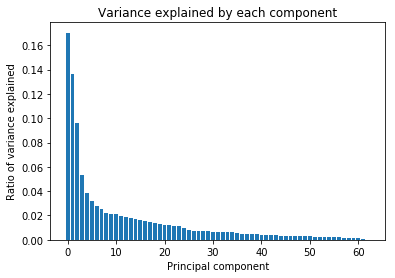

In [43]:
# Investigate the variance accounted for by each principal component.
plt.bar(range(len(pca.explained_variance_ratio_)), pca.explained_variance_ratio_)
plt.title("Variance explained by each component")
plt.xlabel("Principal component")
plt.ylabel("Ratio of variance explained")
plt.show()

In [44]:
np.cumsum(pca.explained_variance_ratio_)

array([ 0.17035823,  0.30684534,  0.40308607,  0.45670634,  0.49491224,
        0.52693478,  0.55509968,  0.58024333,  0.60212114,  0.6235319 ,
        0.64467193,  0.66398354,  0.68312044,  0.70079016,  0.71765106,
        0.7338511 ,  0.74971645,  0.76434033,  0.77776992,  0.79096995,
        0.80320065,  0.81511782,  0.82680173,  0.83785185,  0.84746158,
        0.85546534,  0.86304855,  0.87058105,  0.87793007,  0.88497014,
        0.89162805,  0.89824144,  0.90464247,  0.91085885,  0.91697845,
        0.92257958,  0.92764383,  0.93264493,  0.93722254,  0.94161539,
        0.94580511,  0.9499407 ,  0.9539066 ,  0.95785643,  0.96138776,
        0.96467373,  0.96790111,  0.97098545,  0.97388706,  0.9766474 ,
        0.97937834,  0.98199774,  0.98440386,  0.98666595,  0.98888096,
        0.99086792,  0.99283821,  0.9946561 ,  0.99633084,  0.99778449,
        0.99909885,  1.        ,  1.        ])

In [45]:
# Re-apply PCA to the data while selecting for number of components to retain.
pca_26 = PCA(n_components=26)
azdias_pca = pca_26.fit_transform(azdias_cl_scaled)

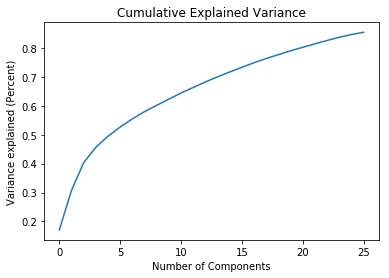

[ 0.17035823  0.30684534  0.40308607  0.45670634  0.49491224  0.52693477
  0.55509967  0.58024331  0.6021211   0.62353178  0.64467159  0.66398294
  0.68311946  0.70078882  0.71764949  0.73384862  0.74971364  0.76433695
  0.7777658   0.79095923  0.80318569  0.81509736  0.8267655   0.83780007
  0.84737873  0.85528907]


In [46]:
plt.plot(range(len(pca_26.explained_variance_ratio_)),np.cumsum(pca_26.explained_variance_ratio_), '-')
plt.title("Cumulative Explained Variance")
plt.xlabel("Number of Components")
plt.ylabel("Variance explained (Percent)")
plt.show()
print(np.cumsum(pca_26.explained_variance_ratio_))

### Discussion 2.2: Perform Dimensionality Reduction

I retained 26 principal components as it explains more than 85% of the features variance.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

In [47]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
def weights(pca, comp):
    df = pd.DataFrame(pca.components_, columns=list(azdias_cl_scaled.columns))
    weights = df.iloc[comp].sort_values(ascending=False)
    return weights

In [48]:
# Weights by feature name of the first component
print(weights(pca_26, 0))

PLZ8_ANTG3               0.226929
PLZ8_ANTG4               0.220157
WEALTH                   0.207419
HH_EINKOMMEN_SCORE       0.203964
ORTSGR_KLS9              0.197979
EWDICHTE                 0.196178
FINANZ_HAUSBAUER         0.162804
KBA05_ANTG4              0.155961
PLZ8_ANTG2               0.154635
FINANZ_SPARER            0.144315
ARBEIT                   0.144098
KBA05_ANTG3              0.138508
ANZ_HAUSHALTE_AKTIV      0.137078
RELAT_AB                 0.135998
SEMIO_PFLICHT            0.113205
SEMIO_REL                0.110426
MOVEMENT                 0.109605
GENERATION               0.097777
SEMIO_RAT                0.093090
SEMIO_TRADV              0.086843
SEMIO_MAT                0.077724
SEMIO_FAM                0.076248
FINANZ_UNAUFFAELLIGER    0.071918
SEMIO_KULT               0.070557
REGIOTYP                 0.068542
FINANZ_ANLEGER           0.067519
OST_WEST_KZ              0.054291
SEMIO_SOZ                0.042168
PLZ8_HHZ                 0.041603
SEMIO_KAEM    

In [49]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(weights(pca_26, 1))

ALTERSKATEGORIE_GROB     0.260905
FINANZ_VORSORGER         0.233403
SEMIO_ERL                0.231390
SEMIO_LUST               0.184171
RETOURTYP_BK_S           0.163817
W_KEIT_KIND_HH           0.119513
FINANZ_HAUSBAUER         0.116847
SEMIO_KRIT               0.115406
SEMIO_KAEM               0.112486
ANREDE_KZ                0.090967
PLZ8_ANTG3               0.089315
EWDICHTE                 0.089310
ORTSGR_KLS9              0.087875
PLZ8_ANTG4               0.085255
WEALTH                   0.072589
SEMIO_DOM                0.070954
KBA05_ANTG4              0.070234
FINANZ_MINIMALIST        0.067124
ARBEIT                   0.065952
RELAT_AB                 0.063413
ANZ_HAUSHALTE_AKTIV      0.061859
PLZ8_ANTG2               0.061765
WOHNDAUER_2008           0.060967
HH_EINKOMMEN_SCORE       0.055055
KBA05_ANTG3              0.045681
ANZ_HH_TITEL             0.030767
OST_WEST_KZ              0.025273
REGIOTYP                 0.017020
MOVEMENT                 0.015432
PLZ8_HHZ      

In [50]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.
print(weights(pca_26, 2))

SEMIO_VERT               0.345075
SEMIO_SOZ                0.262073
SEMIO_FAM                0.249735
SEMIO_KULT               0.234822
FINANZ_MINIMALIST        0.155925
RETOURTYP_BK_S           0.109059
FINANZ_VORSORGER         0.101491
W_KEIT_KIND_HH           0.091375
ALTERSKATEGORIE_GROB     0.079549
SEMIO_REL                0.069211
SEMIO_LUST               0.064982
SEMIO_MAT                0.055738
GREEN_AVANTGARDE         0.047389
ORTSGR_KLS9              0.046786
EWDICHTE                 0.046155
PLZ8_ANTG4               0.045334
PLZ8_ANTG3               0.045011
ARBEIT                   0.035023
WOHNDAUER_2008           0.032921
RELAT_AB                 0.031945
PLZ8_ANTG2               0.030167
KBA05_ANTG4              0.028474
WEALTH                   0.027807
ANZ_HAUSHALTE_AKTIV      0.025438
OST_WEST_KZ              0.015336
ANZ_HH_TITEL             0.013399
KBA05_ANTG3              0.010101
ANZ_TITEL                0.009773
PLZ8_HHZ                 0.003928
SOHO_KZ       

### Discussion 2.3: Interpret Principal Components

(Double-click this cell and replace this text with your own text, reporting your observations from detailed investigation of the first few principal components generated. Can we interpret positive and negative values from them in a meaningful way?)

First component:
* The three features with higher positive correlation are PLZ8_ANTG3 (Number of 6-10 family houses), PLZ8_ANTG4 (Number of 10+ family houses) and WEALTH (Wealth / Life Stage Typology).
* A possible interpretation is that the number of 6-10 and 10+ family houses in the region tend to increase together, and as they increase the share of poor households increases as well.
* The feature with higher negative correlation is MOBI_REGIO (Movement patterns). A possible interpretation is that as the previously mentioned features with positive correlation increase the movement patters of the population increase as well (1 is 'very high movement' and 6 is 'none').

Second component:
* The three features with higher positive correlation are ALTERSKATEGORIE_GROB (Estimated age based on given name analysis), SEMIO_ERL (personality typology / event-oriented) and FINANZ_VORSORGER (Financial typology / be prepared).
* A possible interpretation is as the estimated age increases the affinity to an event oriented personality decreases (7: lowest affinity) and thw tendecy to be prepared financially decreases as well (5: very low).
* The feature with higher negative correlation is SEMIO_REL (Personality typology / religious). A possible interpretation is that as the estimated age increases the affinity to a religious personality increases as well (1: highest affinity)

Third component:
* The three features with higher positive correlation are personality typologies: SEMIO_VERT (dreamful), SEMIO_SOZ (socially-minded) and SEMIO_FAM (family-minded).
* It's interesting that these three features have a negative correlation with ANREDE_KZ (Gender), so as these personaity typologies increase (highest to lowest affinity) they tend to be associated with the male gender (1: male, 2: female).

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [51]:
def get_score(data, k):
    kmeans = KMeans(n_clusters = k)
    model = kmeans.fit(data)
    score = np.abs(model.score(data))
    return score

In [52]:
scores = []
ks = list(range(1,20))
for k in ks:
    scores.append(get_score(azdias_pca, k))

Text(0,0.5,'SSE')

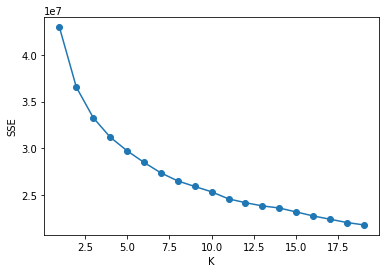

In [53]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.
plt.plot(ks, scores, linestyle='-', marker='o')
plt.xlabel('K');
plt.ylabel('SSE')

In [55]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kms = KMeans(n_clusters = 14)
kms_14 = kms.fit(azdias_pca)
azdias_pred = kms_14.predict(azdias_pca)

### Discussion 3.1: Apply Clustering to General Population

From the representation in the plot above, it looks like 14 as the number of clusters (K) is the elbow. Therefore, 14 is the number of clusters I will use.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [86]:
# Load in the customer demographics data.
cms = pd.read_csv('Udacity_CUSTOMERS_Subset.csv',sep=';')

In [87]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
# Clean data operations
cms_cl = clean_data(cms)

In [88]:
# Check for changes
features = list(cms_cl.columns)
feat_info_cl = feat_info[feat_info['attribute'].isin(features)]
tp_count = feat_info_cl['type'].value_counts()
for i in range(len(tp_count)):
    print('{} {}'.format(tp_count[i], tp_count.index[i]))

49 ordinal
6 numeric
4 categorical


In [89]:
# Replace nan values
cms_cl_imp = pd.DataFrame(imp_miss.fit_transform(cms_cl))
cms_cl_imp.columns = cms_cl.columns
cms_cl_imp.index = cms_cl.index

In [93]:
# Feature scaling
cms_cl_scaled = scaler.transform(cms_cl_imp)
cms_cl_scaled = pd.DataFrame(cms_cl_scaled, columns=list(cms_cl_imp))

In [94]:
# PCA
cms_pca = pca_26.transform(cms_cl_scaled)

In [95]:
# Predict using Kmeans clustering
cms_pred = kms_14.predict(cms_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

Text(0.5,1,'General Population Clusters')

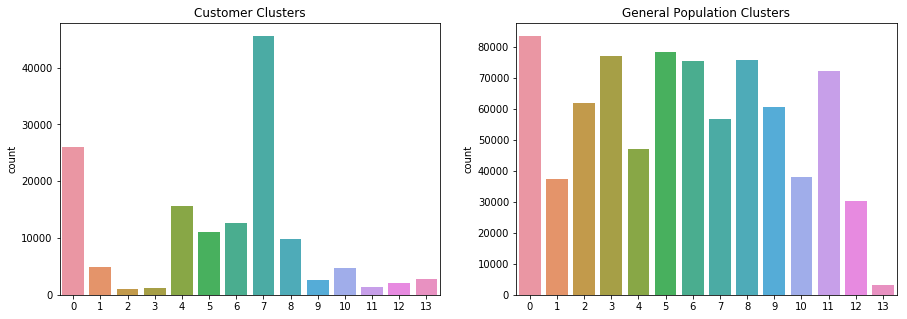

In [112]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
figure, axs = plt.subplots(nrows=1, ncols=2, figsize = (15,5))

sns.countplot(cms_pred, ax=axs[0]) 
axs[0].set_title('Customer Clusters')
sns.countplot(azdias_pred, ax=axs[1])
axs[1].set_title('General Population Clusters')

In [146]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
k_7 = scaler.inverse_transform(pca_26.inverse_transform(kms_14.cluster_centers_[7]))
overrep = pd.Series(data = k_7, index = cms_cl.columns).sort_values(ascending=False)
overrep

MIN_GEBAEUDEJAHR         1993.037916
KBA13_ANZAHL_PKW          690.532663
WOHNDAUER_2008              8.459441
SEMIO_VERT                  6.228117
ORTSGR_KLS9                 5.314327
SEMIO_LUST                  5.269266
SEMIO_KULT                  4.887522
SEMIO_SOZ                   4.879582
FINANZ_MINIMALIST           4.858789
SEMIO_FAM                   4.820078
INNENSTADT                  4.643743
FINANZ_VORSORGER            4.201228
MOBI_REGIO                  4.123922
SEMIO_ERL                   4.118168
W_KEIT_KIND_HH              4.108014
KBA05_GBZ                   4.064009
BALLRAUM                    3.993578
GEBAEUDETYP_RASTER          3.978724
RETOURTYP_BK_S              3.972576
EWDICHTE                    3.918975
SEMIO_MAT                   3.900445
PLZ8_GBZ                    3.884698
SEMIO_REL                   3.727840
PLZ8_HHZ                    3.691385
LIFE_ST                     3.612630
GENERATION                  3.593737
REGIOTYP                    3.547587
K

In [144]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
k_2 = scaler.inverse_transform(pca_26.inverse_transform(kms_14.cluster_centers_[2]))
underrep = pd.Series(data = k_2, index = cms_cl.columns).sort_values(ascending=False)
underrep

MIN_GEBAEUDEJAHR         1992.661897
KBA13_ANZAHL_PKW          520.715454
ANZ_HAUSHALTE_AKTIV        13.706445
WOHNDAUER_2008              7.113188
SEMIO_KULT                  6.889421
ORTSGR_KLS9                 6.889138
SEMIO_FAM                   6.765673
SEMIO_SOZ                   6.703464
SEMIO_REL                   6.338791
SEMIO_VERT                  6.052445
GENERATION                  5.694947
SEMIO_PFLICHT               5.660612
HH_EINKOMMEN_SCORE          5.483742
EWDICHTE                    5.090559
SEMIO_MAT                   5.059640
REGIOTYP                    4.909393
SEMIO_TRADV                 4.864149
FINANZ_SPARER               4.396779
W_KEIT_KIND_HH              4.388452
WEALTH                      4.365226
SEMIO_RAT                   4.107513
FINANZ_UNAUFFAELLIGER       3.816968
PLZ8_HHZ                    3.764958
RELAT_AB                    3.735729
ARBEIT                      3.687632
FINANZ_HAUSBAUER            3.616161
FINANZ_ANLEGER              3.596939
I

### Discussion 3.3: Compare Customer Data to Demographics Data

Based on the analysis represented by the above two plots I can infer that the mail-order sales company is particularly popular with people in clusters 7, 4 and 0, in that order. On the contrary, the company is unpopular with people in clusters 2, 3 and 11.

Considering cluster 7, the company is popular with people with ages between 46 and 60 years old (ALTERSKATEGORIE_GROB = 3.3057) living in prosperous households (WEALTH = 2.1020), which is reflected in a very high estimated household net income (HH_EINKOMMEN_SCORE = 2.4081), and with low movement patterns (MOBI_REGIO = 4.1239). They are male (ANREDE_KZ = 1.0563).

On the contrary, the company is unpopular with people from cluster 2 which have an estimated age of less than 30 years old (ALTERSKATEGORIE_GROB = 1.8048), live in less affluent households (WEALTH = 4.3652) and, as such, have an estimated low household net income (HH_EINKOMMEN_SCORE = 5.4837). They have very high movement patterns (MOBI_REGIO 1.8041) and they also tend to be male (ANREDE_KZ = 0.956341).

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.